In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
import csv
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent.parent
DATA_DIR = BASE_DIR / "oc_mini"

# Add gnn package to path (parent directory)
sys.path.insert(0, str(Path.cwd().parent))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Configuration

You can easily swap the transformer model and data source by modifying these variables below.

# GNN Baseline 2: Jointly Trained Transformer + GNN

**Experiment Goal**: Demonstrate what happens when transformer and GNN are jointly trained together on the train-only graph, and test nodes use the augmented transformer.

**Setup**:
- 90% train nodes, 10% test nodes  
- Create train-only graph (edges only between train nodes)
- **Transformer and GNN are jointly trained** (both trainable)
- Compute embeddings separately:
  - **Train nodes**: Augmented Transformer → GNN (graph-enhanced)
  - **Test nodes**: Augmented Transformer ONLY (weights changed by joint training, but no GNN applied)
- Input: Title + Abstract concatenated

**Key Difference from GNN1**: 
- GNN1: Frozen transformer → test nodes use pre-trained transformer
- GNN2: Trained transformer → test nodes use augmented transformer (but still no graph structure)

**Expected Result**: Test nodes will use the jointly-trained transformer embeddings, which were optimized alongside the GNN but still lack graph connectivity.

---

In [2]:
# Import GNN modules
from model import TransformerGNN
from graph_utils import (
    create_induced_subgraph,
    create_train_only_graph,
    analyze_graph_statistics,
    get_node_texts
)
from split_utils import create_node_based_split

# Data paths
edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"

In [3]:
# Load metadata
metadata_df = pd.read_csv(metadata_path)
print(f"Metadata loaded: {len(metadata_df)} entries")

# Create train/test split (90/10 split)
all_node_ids = [str(node_id) for node_id in metadata_df['id'].values]
train_nodes, test_nodes = create_node_based_split(all_node_ids, test_ratio=0.1, seed=42)

print(f"\nTrain nodes: {len(train_nodes)} ({len(train_nodes)/len(all_node_ids)*100:.1f}%)")
print(f"Test nodes: {len(test_nodes)} ({len(test_nodes)/len(all_node_ids)*100:.1f}%)")

metadata_df.head()

Metadata loaded: 14442 entries

Train nodes: 12998 (90.0%)
Test nodes: 1444 (10.0%)


,id,doi,title,abstract
0,128,10.1101/2021.05.10.443415,Improved protein contact prediction using dime...,AbstractDeep residual learning has shown great...
1,163,10.1101/2021.05.07.443114,Following the Trail of One Million Genomes: Fo...,AbstractSevere acute respiratory syndrome coro...
2,200,10.1101/2021.05.11.443555,Mechanism of molnupiravir-induced SARS-CoV-2 m...,Molnupiravir is an orally available antiviral ...
3,941,10.3390/ijms20020449,Bactericidal and Cytotoxic Properties of Silve...,Silver nanoparticles (AgNPs) can be synthesize...
4,1141,10.3390/ijms20040865,Silver Nanoparticles: Synthesis and Applicatio...,"Over the past few decades, metal nanoparticles..."


In [4]:
# Create train-only graph for GNN
# This graph contains ONLY training nodes with remapped indices 0..N-1
# Test nodes are not included at all

train_edge_index, train_node_to_idx, train_idx_to_node = create_train_only_graph(
    edgelist_path,
    train_nodes
)

print(f"\nTrain-only graph created:")
print(f"  Train nodes: {len(train_node_to_idx)}")
print(f"  Edges: {train_edge_index.shape[1]}")

Loading edgelist from /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv...
  Full graph: 111873 edges

Filtering to edges between 12998 training nodes...
  Filtered edges: 91586

Node mapping (train only):
  Train nodes: 12998
  Index range: 0 to 12997

Final edge_index shape: torch.Size([2, 183172])
  Directed edges: 183172

Train-only graph created:
  Train nodes: 12998
  Edges: 183172


In [ ]:
# Initialize TransformerGNN model with SciBERT
# Key: BOTH Transformer and GNN are TRAINABLE (jointly trained)

model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = TransformerGNN(
    model_name=model_name,
    gnn_type='gcn',           # Use GCN layers
    hidden_dim=768,           # Match SciBERT output
    num_gnn_layers=2,         # 2 GNN layers
    dropout=0.1,
    pooling='cls',
    freeze_transformer=False  # IMPORTANT: Transformer is TRAINABLE!
).to(device)

print("\nModel Summary:")
print(f"  Transformer: {model_name}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable (Transformer + GNN): {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"  Frozen: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")
print(f"\n  BOTH Transformer and GNN will be jointly trained!")

In [ ]:
# Train the model (Transformer + GNN jointly)
from gnn_trainer import train_gnn_epoch_full_graph
from losses import TripletMarginLoss

# Training hyperparameters
epochs = 3
learning_rate = 2e-5
margin = 1.0
num_triplets_per_epoch = 1000

# Loss and optimizer
loss_fn = TripletMarginLoss(margin=margin)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print("="*70)
print("JOINT TRAINING: Transformer + GNN")
print("="*70)
print(f"\nHyperparameters:")
print(f"  Epochs: {epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Margin: {margin}")
print(f"  Triplets per epoch: {num_triplets_per_epoch}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

history = {'train_loss': []}

for epoch in range(epochs):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{epochs}")
    print('='*70)
    
    train_loss = train_gnn_epoch_full_graph(
        model=model,
        train_node_ids=train_node_list,
        edge_index=train_edge_index,
        node_to_idx=train_node_to_idx,
        metadata_df=metadata_df,
        tokenizer=tokenizer,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        num_triplets=num_triplets_per_epoch,
        batch_size=32,
        max_length=512
    )
    
    print(f"\nEpoch {epoch + 1} - Train loss: {train_loss:.4f}")
    history['train_loss'].append(train_loss)

print(f"\n{'='*70}")
print("Training complete!")
print(f"Final loss: {history['train_loss'][-1]:.4f}")
print('='*70)

In [ ]:
# COMPUTE EMBEDDINGS AFTER JOINT TRAINING
# 1. Train nodes: Jointly-trained Transformer → GNN (graph-enhanced)
# 2. Test nodes: Jointly-trained Transformer ONLY (weights augmented by training, but no GNN)

print("="*70)
print("COMPUTING EMBEDDINGS: Train (GNN) vs Test (Augmented Transformer)")
print("="*70)

model.eval()

# Step 1: Get transformer embeddings for TRAIN nodes
# NOTE: Using encode_text() which doesn't compute gradients, but uses the TRAINED weights
print("\n1. Computing embeddings for TRAIN nodes (jointly-trained transformer)...")
train_node_list = [train_idx_to_node[i] for i in range(len(train_idx_to_node))]
train_texts = get_node_texts(train_node_list, metadata_df)

train_transformer_embs = []
batch_size = 32
with torch.no_grad():
    for i in tqdm(range(0, len(train_texts), batch_size), desc="Train transformer"):
        batch_texts = train_texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        batch_embs = model.encode_text(inputs['input_ids'], inputs['attention_mask'])
        train_transformer_embs.append(batch_embs)

train_transformer_embs = torch.cat(train_transformer_embs, dim=0)
print(f"   Train transformer embeddings: {train_transformer_embs.shape}")

# Step 2: Apply GNN to train nodes
print("\n2. Applying GNN to TRAIN nodes...")
with torch.no_grad():
    train_gnn_embs = model(train_transformer_embs, train_edge_index.to(device))
print(f"   Train GNN embeddings: {train_gnn_embs.shape}")

# Step 3: Get AUGMENTED transformer embeddings for TEST nodes
# These use the transformer weights that were modified during joint training
print("\n3. Computing AUGMENTED transformer embeddings for TEST nodes...")
print("   (Using jointly-trained transformer weights, but NO GNN)")
test_texts = get_node_texts(test_nodes, metadata_df)

test_transformer_embs = []
with torch.no_grad():
    for i in tqdm(range(0, len(test_texts), batch_size), desc="Test transformer"):
        batch_texts = test_texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        batch_embs = model.encode_text(inputs['input_ids'], inputs['attention_mask'])
        test_transformer_embs.append(batch_embs)

test_transformer_embs = torch.cat(test_transformer_embs, dim=0)
print(f"   Test transformer embeddings: {test_transformer_embs.shape}")

# Step 4: Create combined embedding dictionary
print("\n4. Creating combined embedding dictionary...")
embeddings_dict = {}

# Add train nodes (with GNN)
train_gnn_embs_np = train_gnn_embs.cpu().numpy()
for i, node_id in enumerate(train_node_list):
    embeddings_dict[node_id] = train_gnn_embs_np[i]

# Add test nodes (augmented transformer-only)
test_transformer_embs_np = test_transformer_embs.cpu().numpy()
for i, node_id in enumerate(test_nodes):
    embeddings_dict[node_id] = test_transformer_embs_np[i]

print(f"   Total embeddings: {len(embeddings_dict)}")
print(f"   Train (GNN-enhanced): {len(train_node_list)}")
print(f"   Test (Augmented Transformer): {len(test_nodes)}")

print("\n" + "="*70)
print("GNN2 RESULT:")
print("- Train nodes: Jointly-trained Transformer → GNN (graph-enhanced)")
print("- Test nodes: Jointly-trained Transformer ONLY (no graph structure)")
print("\nKey difference from GNN1:")
print("  GNN1: Test nodes use PRE-TRAINED transformer")
print("  GNN2: Test nodes use JOINTLY-TRAINED transformer (augmented weights)")
print("="*70)

In [ ]:
# VERIFICATION: Compare test embeddings - Pre-trained vs Jointly-trained Transformer
# This shows how joint training changed the transformer weights

print("="*70)
print("VERIFICATION: Pre-trained vs Jointly-trained Transformer")
print("="*70)

# Load pre-trained model for comparison
print("\nLoading pre-trained SciBERT for comparison...")
from transformers import AutoModel
pretrained_encoder = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased').to(device)
pretrained_encoder.eval()

# Sample some test nodes
import random
random.seed(42)
sample_test_nodes = random.sample(test_nodes, min(10, len(test_nodes)))

print(f"\nComparing {len(sample_test_nodes)} test nodes:")
print(f"  1. Pre-trained SciBERT (baseline)")
print(f"  2. Jointly-trained Transformer (augmented by GNN training)\n")

cosine_sims = []
l2_diffs = []

for node_id in sample_test_nodes:
    # Get jointly-trained embedding (from our model)
    jointly_trained_emb = embeddings_dict[node_id]
    
    # Compute pre-trained embedding
    text = get_node_texts([node_id], metadata_df)[0]
    with torch.no_grad():
        inputs = tokenizer(
            [text],
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        
        # Pre-trained SciBERT
        outputs = pretrained_encoder(**inputs)
        pretrained_emb = outputs.last_hidden_state[:, 0, :]  # CLS token
        pretrained_emb = torch.nn.functional.normalize(pretrained_emb, p=2, dim=1)
        pretrained_emb = pretrained_emb.cpu().numpy()[0]
    
    # Compare
    cosine_sim = (pretrained_emb * jointly_trained_emb).sum()
    l2_diff = np.sqrt(((pretrained_emb * jointly_trained_emb) ** 2).sum())
    
    cosine_sims.append(cosine_sim)
    l2_diffs.append(l2_diff)
    
    print(f"Node {node_id}:")
    print(f"  Cosine similarity: {cosine_sim:.6f}")
    print(f"  L2 difference: {l2_diff:.6f}")

print(f"\n{'-'*70}")
print(f"Summary across {len(sample_test_nodes)} test nodes:")
print(f"  Mean cosine similarity: {np.mean(cosine_sims):.6f}")
print(f"  Mean L2 difference: {np.mean(l2_diffs):.6f}")

if np.mean(cosine_sims) < 0.99:
    print(f"\n✓ VERIFIED: Transformer weights changed during joint training")
    print(f"  Test nodes now use augmented transformer (not pre-trained)")
else:
    print(f"\n✗ WARNING: Embeddings very similar (may not have trained enough)")

print("="*70)

# Clean up
del pretrained_encoder
torch.cuda.empty_cache() if torch.cuda.is_available() else None

In [11]:
# VERIFICATION: Test nodes should have identical embeddings pre and post "GNN"
# Since we didn't apply GNN to test nodes, their embeddings should be unchanged

print("="*70)
print("VERIFICATION: Test Node Embeddings Pre vs Post GNN")
print("="*70)

# Sample some test nodes
import random
random.seed(42)
sample_test_nodes = random.sample(test_nodes, min(10000000, len(test_nodes)))

if len(sample_test_nodes) < len(test_nodes):
    print(f"\nComparing {len(sample_test_nodes)} random test nodes...")
else:
    print(f"\nComparing all test nodes pre and post-GNN...")
print(f"Expected: Cosine similarity = 1.0 (identical embeddings)\n")

cosine_sims = []
l2_diffs = []

for node_id in sample_test_nodes:
    # Get the "post-GNN" embedding (which is actually just transformer)
    post_gnn_emb = embeddings_dict[node_id]
    
    # Compute transformer embedding again for comparison
    text = get_node_texts([node_id], metadata_df)[0]
    with torch.no_grad():
        inputs = tokenizer(
            [text],
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        pre_gnn_emb = model.encode_text(inputs['input_ids'], inputs['attention_mask'])
        pre_gnn_emb = pre_gnn_emb.cpu().numpy()[0]
    
    # Compare
    cosine_sim = (pre_gnn_emb * post_gnn_emb).sum()
    l2_diff = np.sqrt(((pre_gnn_emb - post_gnn_emb) ** 2).sum())
    
    cosine_sims.append(cosine_sim)
    l2_diffs.append(l2_diff)
    
    #print(f"Node {node_id}:")
    #print(f"  Cosine similarity: {cosine_sim:.10f}")
    #print(f"  L2 difference: {l2_diff:.10e}")

print(f"\n{'-'*70}")
print(f"Summary across {len(sample_test_nodes)} test nodes:")
print(f"  Mean cosine similarity: {np.mean(cosine_sims):.10f}")
print(f"  Min cosine similarity: {np.min(cosine_sims):.10f}")
print(f"  Mean L2 difference: {np.mean(l2_diffs):.10e}")
print(f"  Max L2 difference: {np.max(l2_diffs):.10e}")

if np.mean(cosine_sims) > 0.9999:
    print(f"\n✓ VERIFIED: Test embeddings are identical (no GNN applied)")
else:
    print(f"\n✗ WARNING: Test embeddings differ (unexpected!)")

print("="*70)

VERIFICATION: Test Node Embeddings Pre vs Post GNN

Comparing all test nodes pre and post-GNN...
Expected: Cosine similarity = 1.0 (identical embeddings)


----------------------------------------------------------------------
Summary across 1444 test nodes:
  Mean cosine similarity: 1.0000000000
  Min cosine similarity: 0.9999997616
  Mean L2 difference: 1.0989252814e-06
  Max L2 difference: 2.9529346648e-06

✓ VERIFIED: Test embeddings are identical (no GNN applied)


Evaluating on test set: 1444 nodes

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0092
    Precision Normalized@5: 0.0094
    Recall@5: 0.0038
    Hit Rate@5: 0.0445
  K=10:
    Precision@10: 0.0072
    Precision Normalized@10: 0.0086
    Recall@10: 0.0059
    Hit Rate@10: 0.0632
  K=20:
    Precision@20: 0.0064
    Precision Normalized@20: 0.0118
    Recall@20: 0.0107
    Hit Rate@20: 0.1098
  K=50:
    Precision@50: 0.0049
    Precision Normalized@50: 0.0198
    Recall@50: 0.0193
    Hit Rate@50: 0.1967
  K=100:
    Precision@100: 0.0036
    Precision Normalized@100: 0.0276
    Recall@100: 0.0274
    Hit Rate@100: 0.2738

AUC Metrics:
  AUC-ROC: 0.4466
  AUC-PR: 0.0972



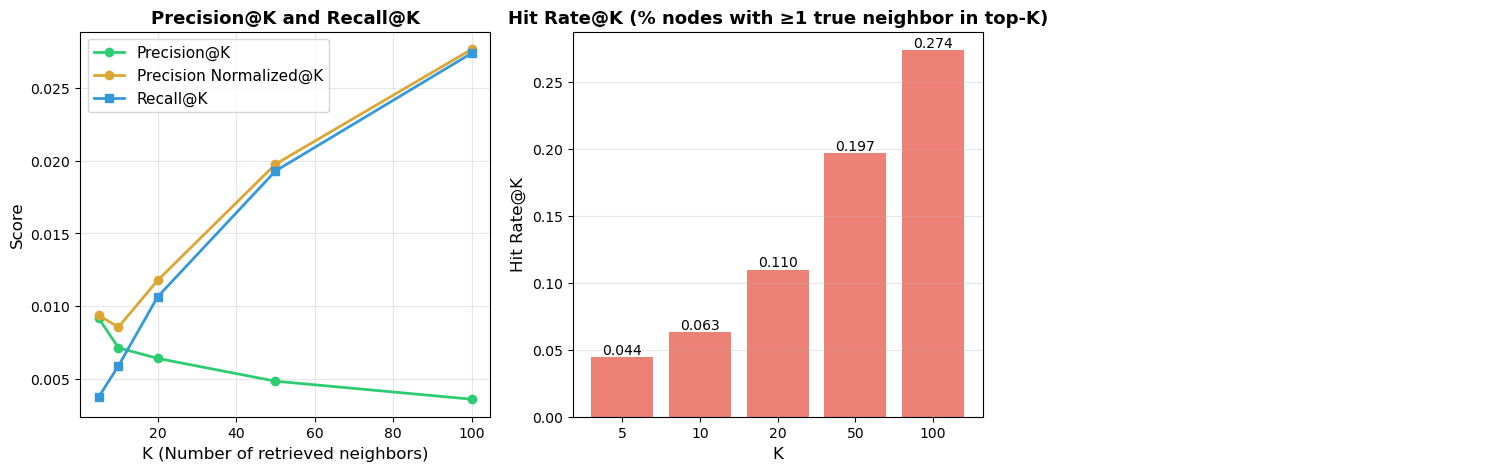

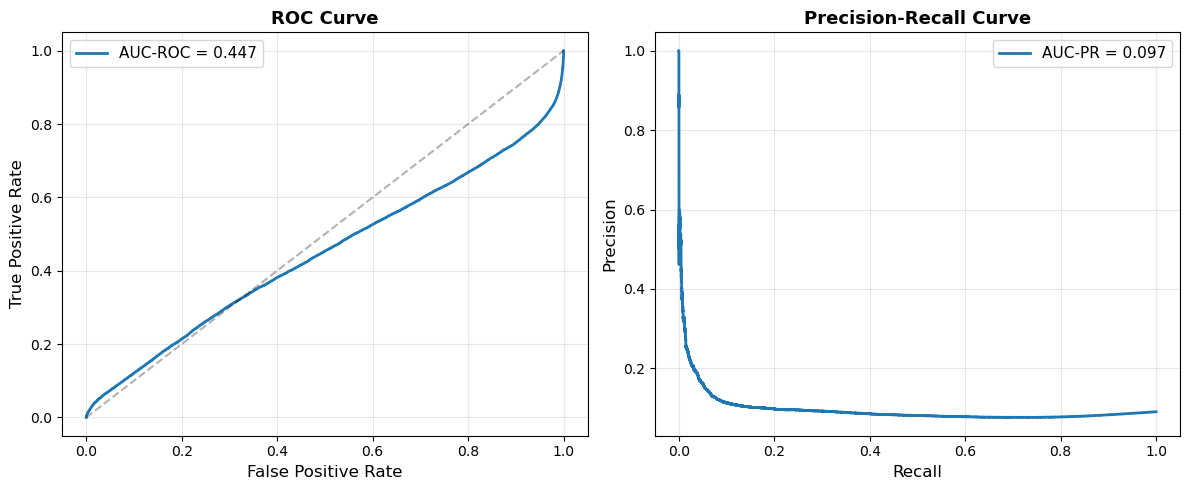

<Figure size 640x480 with 0 Axes>

In [9]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat" / "utils" / "evaluation"))

from link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results
)

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Evaluate fine-tuned model using the SAME nodes as validation
print(f"Evaluating on test set: {len(test_nodes)} nodes")
results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_nodes,  # Same as validation nodes
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(results['topk'], results['auc'])